<a href="https://colab.research.google.com/github/ethanelkaim/Deep-Learning-Models/blob/main/GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import pickle

In [ ]:
def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x


def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


def save_models(D, G, filename):
    models = {'D': D.state_dict(), 'G': G.state_dict()}
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset_path = '/content/drive/MyDrive/celeba'

In [ ]:
# Define transformations
channels = 3
image_size = 256
batch_size = 50

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the dataset
celeba_dataset = ImageFolder(root=dataset_path, transform=transform)
data_loader = DataLoader(dataset=celeba_dataset, batch_size=batch_size,  shuffle=True)

In [ ]:
hidden_dim = 256
latent_dim = 64

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size * image_size * channels, hidden_dim),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_dim, hidden_dim),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_dim, 1),
    nn.Sigmoid())

# Generator
G = nn.Sequential(
    nn.Linear(latent_dim, hidden_dim),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_dim, hidden_dim),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_dim, image_size * image_size * channels),
    nn.Tanh())

D = to_cuda(D)
G = to_cuda(G)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

In [ ]:
def train_GAN(D, G, d_optimizer, g_optimizer, criterion, data_loader, num_epochs, latent_dim, image_size, channels):
    torch.manual_seed(42)

    d_loss_by_epochs = []
    g_loss_by_epochs = []
    generated_images = []

    for epoch in tqdm(range(num_epochs), desc='epochs'):
        accuracy_real = 0
        accuracy_fake = 0

        total_loss_discriminator = 0
        total_loss_generator = 0

        for images, _ in data_loader:
            # Build mini-batch dataset
            batch_size = images.size(0)
            images = to_cuda(images.view(batch_size, -1))

            # Create the labels which are later used as input for the BCE loss
            real_labels = to_cuda(torch.ones(batch_size))
            fake_labels = to_cuda(torch.zeros(batch_size))

            #============= Train the discriminator =============#
            # Compute BCE_Loss using real images where BCE_Loss(x, y):
            #         - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            D.train()
            G.train(False) # <-> G.eval()

            outputs = D(images) # Real images
            d_loss_real = criterion(outputs.squeeze(1), real_labels)
            real_score = outputs

            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = to_cuda(torch.randn(batch_size, latent_dim))
            fake_images = G(z) # Generate fake images
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs.squeeze(1), fake_labels)
            fake_score = outputs

            # Backprop + Optimize
            d_loss = d_loss_real + d_loss_fake
            total_loss_discriminator += d_loss
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #=============== Train the generator ===============#
            # Compute loss with fake images
            D.train(False)
            G.train()
            z = to_cuda(torch.randn(batch_size, latent_dim))
            fake_images = G(z)
            outputs = D(fake_images)

            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            g_loss = criterion(outputs.squeeze(1), real_labels)
            total_loss_generator += g_loss

            # Backprop + Optimize
            D.zero_grad()
            G.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        d_loss_by_epochs.append((total_loss_discriminator / len(data_loader)).item())
        g_loss_by_epochs.append((total_loss_generator / len(data_loader)).item())

        fake_image = fake_images.data[0].view(channels, image_size, image_size)
        fake_image = denorm(fake_image).permute(1, 2, 0).cpu().numpy()
        generated_images.append(fake_image)
        plt.imshow(fake_image)
        plt.show()

    return d_loss_by_epochs, g_loss_by_epochs

In [ ]:
d_loss_by_epochs, g_loss_by_epochs = train_GAN(D, G, d_optimizer, g_optimizer, criterion, data_loader,
                                               num_epochs=300, latent_dim=latent_dim, image_size=image_size, channels=3)

In [ ]:
save_models(D, G, "/content/HW3_342791324_931214522.pkl")

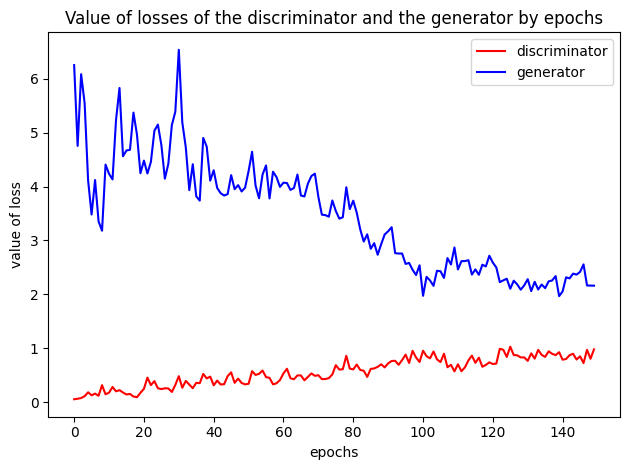

In [ ]:
epochs = [i for i in range(150)]

plt.plot(epochs, d_loss_by_epochs, label='discriminator', color='red')
plt.plot(epochs, g_loss_by_epochs, label='generator', color='blue')


plt.title('Value of losses of the discriminator and the generator by epochs')
plt.xlabel('epochs')
plt.ylabel('value of loss')

plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
def test_GAN(generator, latent_dim):
    torch.manual_seed(3)

    generator.eval()
    num_test_samples = 10

    with torch.no_grad():
        z = to_cuda(torch.randn(num_test_samples, latent_dim))
        generated_images = generator(z)

    fig, axes = plt.subplots(1, num_test_samples, figsize=(15, 15))

    for i in range(num_test_samples):
        temp = generated_images[i].view(3, 64, 64)
        image = denorm(temp).permute(1, 2, 0).cpu().numpy()

        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

In [ ]:
test_GAN(G, latent_dim=64)

In [ ]:
def pick_not_similar_vectors():
    z = to_cuda(torch.randn(1, 64))
    minus_z = to_cuda(z * (-1))
    return z, minus_z


def pick_big_norm_vectors():
    z = to_cuda(torch.randn(1, 64))
    triple_z = to_cuda(z * 3)
    return z, triple_z

In [ ]:
def visualization_latent_space(G, pick_method_vector):
    num_couples_sample = 10
    fake_vectors = []

    with torch.no_grad():
      # Generate two vectors with minimum cosine similarity
        for i in range(num_couples_sample):
            z, z_modified = pick_method_vector()

            fake_vectors.append(z)
            fake_vectors.append(z_modified)

        fake_vectors_tensor = to_cuda(torch.stack(fake_vectors))
        generated_images = to_cuda(G(fake_vectors_tensor))

    fig, axes = plt.subplots(num_couples_sample, 2, figsize=(3, 12))
    for i in range(num_couples_sample):
        for j in range(2):
          temp = generated_images[2 * i + j].view(3, 64, 64)
          image = denorm(temp).permute(1, 2, 0).cpu().numpy()

          axes[i][j].imshow(image)
          axes[i][j].axis('off')

    plt.show()

************************************************************************************************************************
Effect of picking two vectors with minimal cosine similarity from the latent space in generation of images:


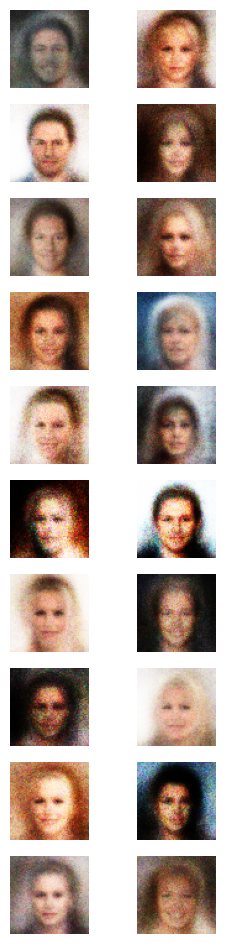

************************************************************************************************************************
Effect of picking two same vectors with increasing norms from the latent space in generation of images:


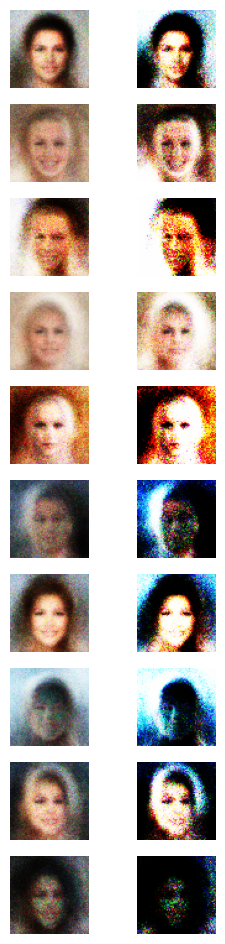

In [ ]:
print("*" * 120)
print("Effect of picking two vectors with minimal cosine similarity from the latent space in generation of images:")
visualization_latent_space(G, pick_not_similar_vectors)

print("*" * 120)
print("Effect of picking two same vectors with increasing norms from the latent space in generation of images:")
visualization_latent_space(G, pick_big_norm_vectors)